In [2]:
%matplotlib inline
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, IBMQ
from qiskit.tools.monitor import backend_overview, backend_monitor
from qiskit.compiler import transpile, assemble
from qiskit.visualization import *
from qiskit.transpiler import *
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer
import pprint

Transpilation consists of several circuit transformatins - known as passes.
Pass manager schedules the passes and allows them to communicate with each other by providing a shared space.
Thanks to this transpiler is opened for optimizations.
DAG = Directed Acyclic Graph
DAG is the internal Qiskit representation of circuit.


In [3]:
provider = IBMQ.load_account()

In [4]:
backend_overview()

ibmq_essex                   ibmq_burlington              ibmq_london
----------                   ---------------              -----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 6              Pending Jobs: 4              Pending Jobs: 6
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      98.0           Avg. T1:      83.5           Avg. T1:      68.3
Avg. T2:      126.3          Avg. T2:      57.2           Avg. T2:      75.2



ibmq_ourense                 ibmq_vigo                    ibmq_16_melbourne
------------                 ---------                    -----------------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  14
Pending Jobs: 16             Pending Jobs: 12             Pending Jobs: 10
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True  

In [5]:
real_backend = provider.get_backend('ibmq_16_melbourne')

In [5]:
backend_monitor(real_backend)

ibmq_16_melbourne
Configuration
-------------
    n_qubits: 14
    operational: True
    status_msg: active
    pending_jobs: 12
    backend_version: 1.0.0
    basis_gates: ['u1', 'u2', 'u3', 'cx', 'id']
    local: False
    simulator: False
    sample_name: albatross
    memory: False
    allow_q_circuit: False
    url: None
    allow_q_object: True
    online_date: 2018-11-06T05:00:00+00:00
    max_experiments: 150
    description: 14 qubit device
    open_pulse: False
    coupling_map: [[1, 0], [1, 2], [2, 3], [4, 3], [4, 10], [5, 4], [5, 6], [5, 9], [6, 8], [7, 8], [9, 8], [9, 10], [11, 3], [11, 10], [11, 12], [12, 2], [13, 1], [13, 12]]
    allow_object_storage: True
    credits_required: True
    backend_name: ibmq_16_melbourne
    max_shots: 8192
    n_registers: 1
    conditional: False

Qubits [Name / Freq / T1 / T2 / U1 err / U2 err / U3 err / Readout err]
-----------------------------------------------------------------------
    Q0 / 5.10014 GHz / 55.53076 µs / 22.11239 µs 

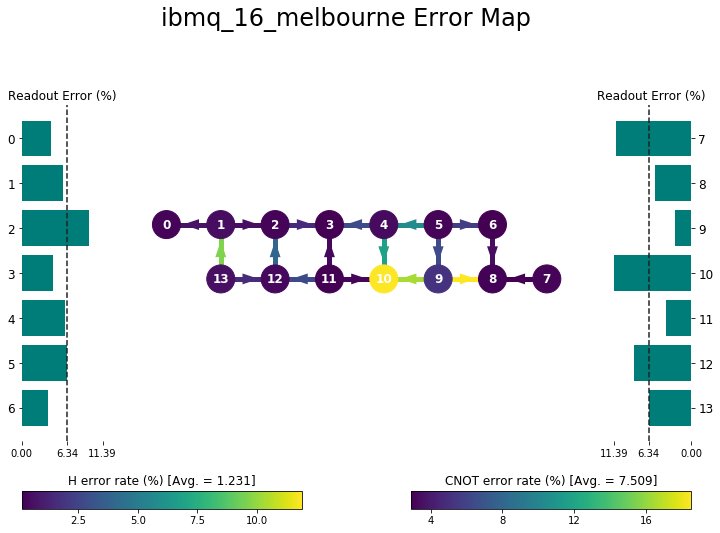

In [6]:
plot_error_map(real_backend)

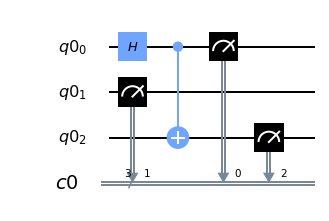

In [7]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
circuit = QuantumCircuit(qr, cr)

circuit.h(qr[0])
circuit.cx(qr[0], qr[2])
circuit.measure(qr, cr)

circuit.draw(output='mpl')

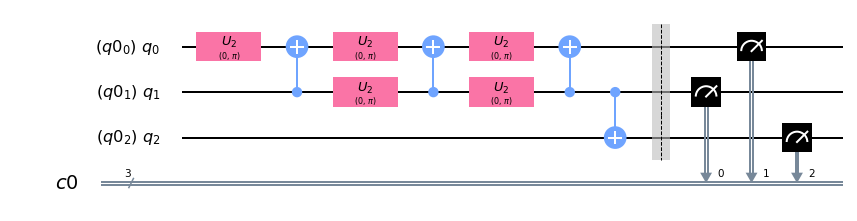

In [8]:
compiled_circuit = transpile(circuit, real_backend)
compiled_circuit.draw(output='mpl', idle_wires=False)

Transpilation (re-writing circuits) versus compilation (circuit into set of pulses) 

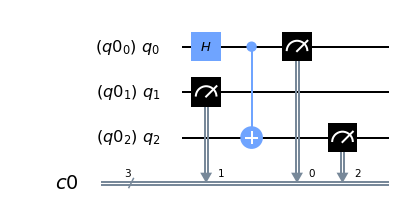

In [9]:
#Transpilation on any backend (by providing custom coupling map)
from qiskit.transpiler import CouplingMap

compiled_circuit_custom_backend = transpile(circuit, coupling_map=CouplingMap([[0, 1],[0, 2]]))
#EXERCISE: Check if analogy to Melbourne connections will produce the same circuit

compiled_circuit_custom_backend.draw(output='mpl', idle_wires=False)

## Transpiler optimization levels

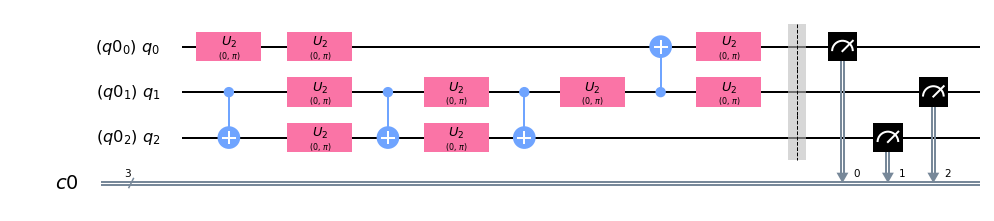

In [15]:
#The default optimization level is 1.
#The bigger level, the heavier optimization (as you can see)
#EXERCISE - check level 2 or 3. These benefit from backend properties!!!
compiled_circuit = transpile(circuit, real_backend, optimization_level=0)
compiled_circuit.draw(output='mpl', idle_wires=False)

As can be seen, BackendProperties taken from backend allowed to choose optimal two qubits (with smallest errors), not just random two connected with each other.

Providing backend is optional. One can compile for any topology specified as input to transpiler.

* `optimization_level=0`: just maps the circuit to the backend, with no explicit optimization (except whatever optimizations the mapper does)

* `optimization_level=1`: maps the circuit, but also does light-weight optimizations by collapsing adjacent gates.

* `optimization_level=2`: medium-weight optimization, including a noise-adaptive layout and a gate-cancellation procedure based on gate commutation relationships.

* `optimization_level=3`: heavy-weight optimization, which in addition to previous steps, does resynthesis of two-qubit blocks of gates in the circuit.


Transpiler uses predefined so called PassManager (depending on optimization level). However, one can use a custom PassManager which will be tuned for certain applications.

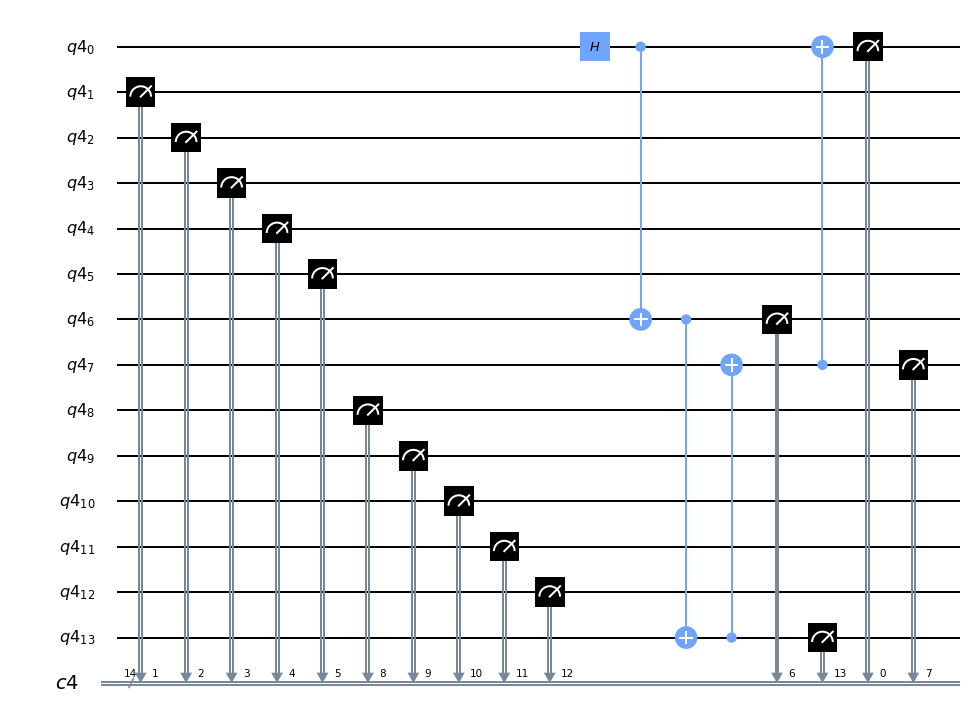

In [15]:
#Now let's do something more dificult:

qr2 = QuantumRegister(14)
cr2 = ClassicalRegister(14)
circuit2 = QuantumCircuit(qr2, cr2)

circuit2.h(qr2[0])
circuit2.cx(qr2[0], qr2[6])
circuit2.cx(qr2[6], qr2[13])
circuit2.cx(qr2[13], qr2[7])
circuit2.cx(qr2[7], qr2[0])
circuit2.measure(qr2, cr2)

circuit2.draw(output='mpl')

In [16]:
for level in range(4):
    compiled_circuit2 = transpile(circuit2, real_backend, optimization_level=level)
    print('---------- Level = ' + str(level) + '----------')
    print('gates = ', compiled_circuit2.count_ops())
    print('depth = ', compiled_circuit2.depth())

---------- Level = 0----------
gates =  OrderedDict([('u2', 65), ('cx', 46), ('measure', 14), ('barrier', 1)])
depth =  44
---------- Level = 1----------
gates =  OrderedDict([('u2', 65), ('cx', 40), ('measure', 14), ('barrier', 1)])
depth =  44
---------- Level = 2----------
gates =  OrderedDict([('measure', 14), ('u2', 9), ('cx', 4)])
depth =  10
---------- Level = 3----------
gates =  OrderedDict([('measure', 14), ('u2', 9), ('cx', 4)])
depth =  10


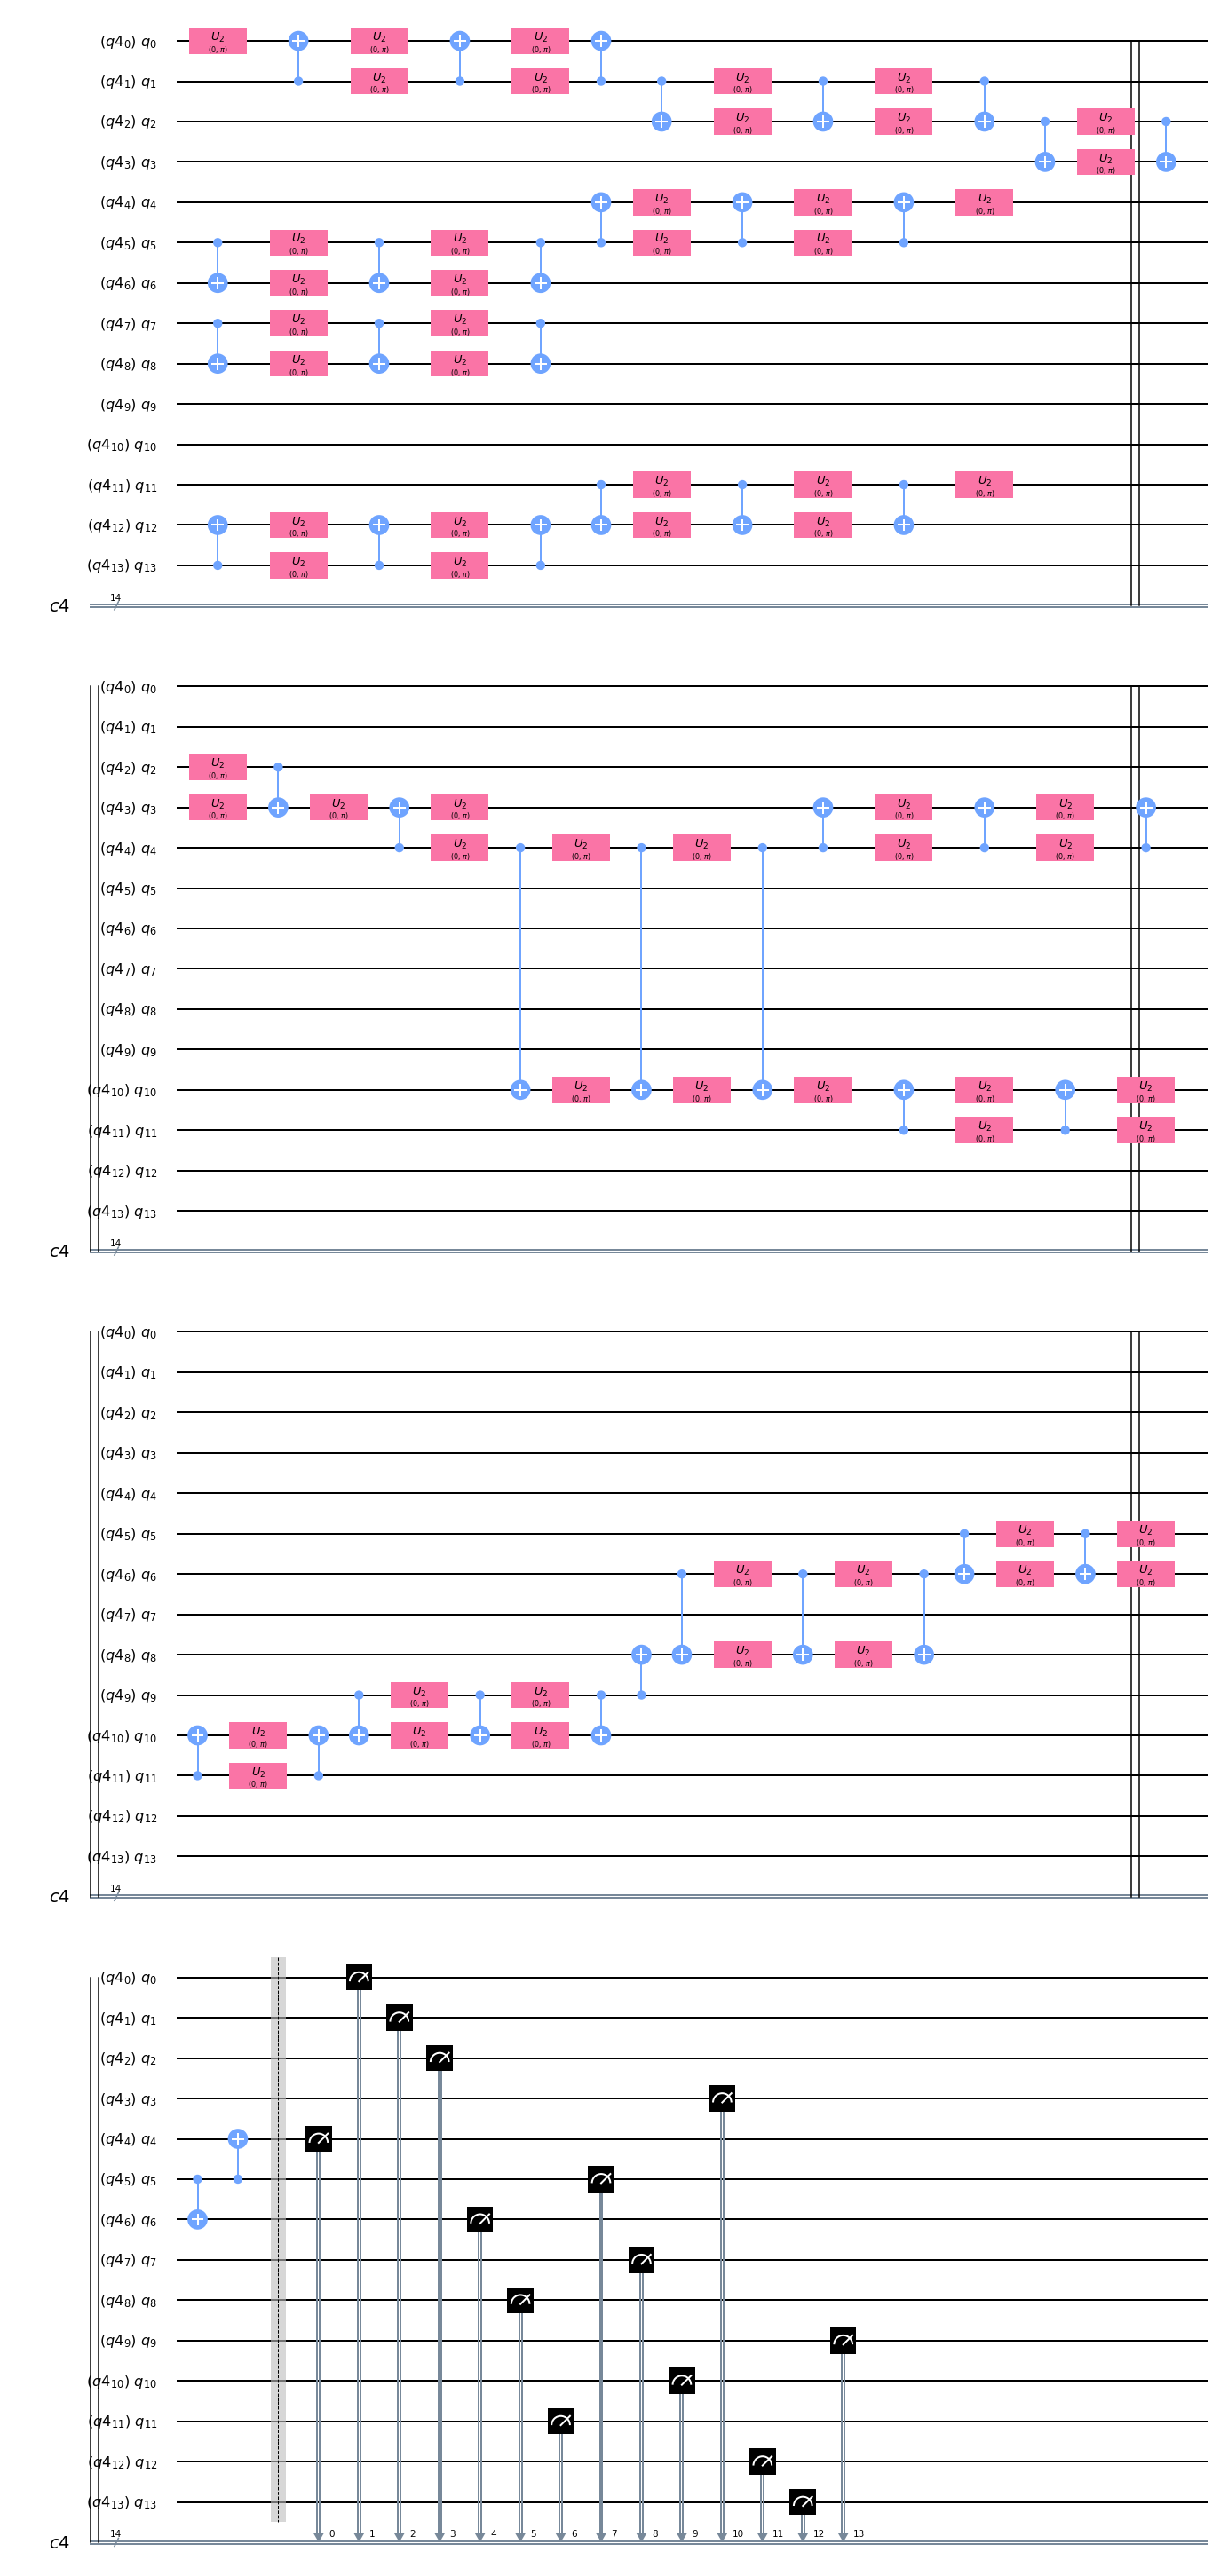

In [18]:
compiled_circuit2 = transpile(circuit2, real_backend, optimization_level=0)
compiled_circuit2.draw(output='mpl', idle_wires=False)

## What transpiler does?

In [19]:
import logging
logging.basicConfig(level='DEBUG')

In [25]:
import logging

#logging.getLogger('qiskit.transpiler').setLevel('INFO')
transpile(circuit, real_backend, optimization_level=3)

#EXERCISE: check logging on various optimization levels

INFO:qiskit.transpiler.passmanager:Pass: Unroller - 0.00000 (ms)
INFO:qiskit.transpiler.passmanager:Pass: SetLayout - 0.00000 (ms)
INFO:qiskit.transpiler.passmanager:Pass: NoiseAdaptiveLayout - 3.98660 (ms)
INFO:qiskit.transpiler.passmanager:Pass: FullAncillaAllocation - 0.00000 (ms)
INFO:qiskit.transpiler.passmanager:Pass: EnlargeWithAncilla - 0.99897 (ms)
INFO:qiskit.transpiler.passmanager:Pass: ApplyLayout - 2.99978 (ms)
INFO:qiskit.transpiler.passmanager:Pass: CheckMap - 3.00360 (ms)
INFO:qiskit.transpiler.passmanager:Pass: CheckCXDirection - 0.00000 (ms)
INFO:qiskit.transpiler.passmanager:Pass: Depth - 1.99986 (ms)
INFO:qiskit.transpiler.passmanager:Pass: FixedPoint - 0.00000 (ms)
INFO:qiskit.transpiler.passmanager:Pass: RemoveResetInZeroState - 0.00000 (ms)
INFO:qiskit.transpiler.passmanager:Pass: Collect2qBlocks - 4.99892 (ms)
INFO:qiskit.transpiler.passmanager:Pass: ConsolidateBlocks - 7.00092 (ms)
INFO:qiskit.transpiler.passmanager:Pass: Unroller - 0.00000 (ms)
INFO:qiskit.tra

Transpiler uses Pass Manager to do a set of passes transforming the circuit until the final shape.

In [26]:
#Getting info about all existing transpiler passes:

from qiskit.transpiler import passes
for passitem in dir(passes):
    if passitem[0].isupper(): print(passitem)


ApplyLayout
BarrierBeforeFinalMeasurements
BasicSwap
CXCancellation
CXDirection
CheckCXDirection
CheckMap
Collect2qBlocks
CommutationAnalysis
CommutativeCancellation
ConsolidateBlocks
CountOps
CountOpsLongestPath
DAGFixedPoint
DAGLongestPath
Decompose
DenseLayout
Depth
EnlargeWithAncilla
FixedPoint
FullAncillaAllocation
LookaheadSwap
MergeAdjacentBarriers
NoiseAdaptiveLayout
NumTensorFactors
Optimize1qGates
OptimizeSwapBeforeMeasure
RemoveDiagonalGatesBeforeMeasure
RemoveResetInZeroState
ResourceEstimation
SetLayout
Size
StochasticSwap
TrivialLayout
Unroll3qOrMore
Unroller
Width


Passes can be transformation passes or analysis passes.

## How to use custom transpiler (custom pass manager)?
### Example: expressing desired circuit using only natively implemented gates: Unroller

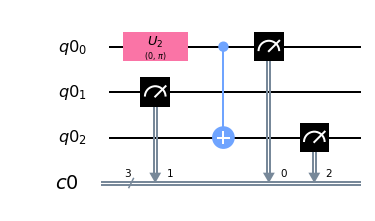

In [20]:
from qiskit.transpiler.passes import Unroller

# PassManager(passes=None, max_iteration=None, callback=None)
pm = PassManager(Unroller(['u1', 'u2', 'u3', 'cx']))
# EXERCISE: If one would have a backend with natively implemented H gate, it can be provided to Unroller.

new_circuit = pm.run(circuit)
new_circuit.draw(output='mpl')

## How Pass Manager works under the cover?




In Qiskit, we represent circuits internally using a Directed Acyclic Graph (DAG).

Each pass can either analyze the circuit and write conclusions in a commonly accessible properties or transform the circuit by using the properties from analysis (in read-only mode)

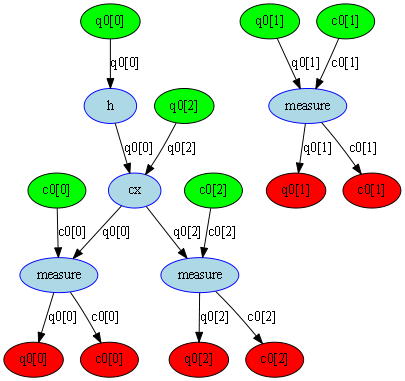

In [28]:
dag = circuit_to_dag(circuit)
dag_drawer(dag)

Three kinds of graph nodes exist: qubit/clbit input nodes (green), operation nodes (blue), and output nodes (red). Each edge indicates data flow (or dependency) between two nodes.

INFO:qiskit.transpiler.passmanager:Pass: Unroller - 1.00160 (ms)


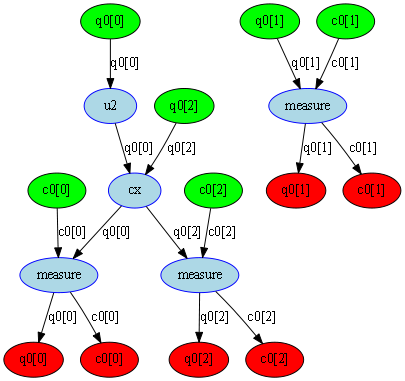

In [29]:
from qiskit.transpiler.passes import Unroller

pm = PassManager()
pm.append(Unroller(['id','u1','u2','u3','cx']))
new_circuit = pm.run(circuit)
dag = circuit_to_dag(new_circuit)
dag_drawer(dag)

In [21]:
from qiskit.transpiler.passes import Depth

pm.append(Depth())
new_circuit = pm.run(circuit)

pm.property_set


{'depth': 3}